In [1]:
import numpy as np
import copy
import re
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from hmmlearn import hmm
from itertools import chain
np.random.seed(42)
pd.options.display.max_rows = 20

In [2]:
VAL = False
%config InlineBackend.figure_format = 'png'

## Computing the parameters for the HMM

### Extracting steps for all videos

First let's read the annotation files of the videos to get the sequence of steps for each video

In [3]:
videos_true_length = []
videos = []
for i in range(1,28):
    steps = map(lambda x: x.strip().split("\t")[1], open("../annotations/workflow_video_%02d.txt" % i, "r").readlines()[1:])
    videos.append(steps[24::25]) # keep 1 frame out of 25
    videos_true_length.append(len(steps)) # keep 1 frame out of 25

### Getting steps

We want a list of the unique steps that can appear in the sequence. First we will compute this set from the data. But
this set won't match the usual order of the steps so we will eventually use a set written by hand. As a sanity check we
will compare this manually-written set with the computed one to make sure they match.

In [4]:
unique_steps = list(reduce(lambda s1, s2: s1.union(s2), map(lambda s: set(s), videos)))

# Manual writting of steps to have meaningful order
ordered_unique_steps = \
    ["TrocarPlacement", "Preparation", "CalotTriangleDissection", "ClippingCutting", "GallbladderDissection",
     "GallbladderPackaging", "CleaningCoagulation", "GallbladderRetraction"]
p = len(ordered_unique_steps)

if len(set(ordered_unique_steps).difference(set(unique_steps))) > 0:
    raise Exception("Sets do not match")
else:
    print ordered_unique_steps

['TrocarPlacement', 'Preparation', 'CalotTriangleDissection', 'ClippingCutting', 'GallbladderDissection', 'GallbladderPackaging', 'CleaningCoagulation', 'GallbladderRetraction']


In [5]:
# This map will be used to get the index of a string step
step_index = {v: k for k, v in zip(range(p), ordered_unique_steps)}

### Computing transition / start statistics

Le'ts take a look at the transition statistics between each pair of steps and start probability

In [6]:
pi = np.zeros(p)

for steps in videos:
    pi[step_index[steps[0]]] += 1
pi /= len(videos)

print "pi:"
print pi

pi:
[ 1.  0.  0.  0.  0.  0.  0.  0.]


[[  9.94504376e-01   5.49562386e-03   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.90228013e-01   9.77198697e-03   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.98417536e-01   1.58246395e-03
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   9.96450638e-01
    3.54936243e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    9.98397626e-01   1.18694362e-03   4.15430267e-04   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   9.85381700e-01   9.20411478e-03   5.41418517e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   8.22368421e-04   9.97180451e-01   1.99718045e-03]
 [  0.0000000

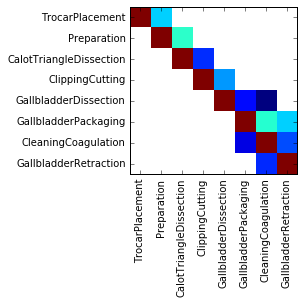

In [7]:
A = np.zeros((p,p))

for steps in videos:
    for (s1, s2) in zip(steps[0:-1], steps[1:]):
        A[step_index[s1], step_index[s2]] += 1

A /= np.sum(A, axis=1, keepdims=True)

print A
plt.figure(figsize=(3,3))
plt.imshow(np.log(A), interpolation="nearest")
plt.xticks(range(p),ordered_unique_steps, rotation=90)
plt.yticks(range(p),ordered_unique_steps)
plt.show()

### Computing emission statistics

In the HMM continuous gaussian model, for each hidden state, we emit an observed data vector based on a gaussian distribution. Let's compute mean and variance of these gaussians.

In [10]:
# Read train data for emission

def processEmission(l):
    data = l.strip().split(";")
    vidInfo = re.search(r"_([0-9]+)-([0-9]+)", data[0])
    return (int(vidInfo.group(1)) - 1, int(vidInfo.group(2)) -1, int(data[1]) - 1, map(float, data[3:]))

train_pred_seq = map(processEmission, open("../cnnPreds/trainextract.csv", "r").readlines()[1:])

In [11]:
test_pred_seq = map(processEmission, open("../cnnPreds/valextract.csv", "r").readlines()[1:])

In [13]:
test_pred_seq_df = pd.DataFrame(test_pred_seq, columns=["vid","frame", "class", "probas"])
test_pred_seq_df

,vid,frame,probas
0,8,14,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,8,15,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,8,16,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,8,17,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,8,18,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
5,8,19,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,8,20,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,8,0,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,8,1,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,8,2,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [14]:
test_pred_probas_ids = []
test_pred_probas = []
test_pred_probas_gt = []

for vidId, group in test_pred_seq_df.groupby("vid"):
    if (len(videos[vidId]) != len(set(group["frame"].tolist()))):
        print len(videos[vidId])
        print len(set(group["frame"].tolist()))
        raise Exception("Bad number of frames for video %d" % vidId)

    group = group.sort("frame")
    
    test_pred_probas_ids.append(vidId)
    test_pred_probas.append(group["probas"].tolist())
    test_pred_probas_gt.append(group["class"].tolist())

KeyError: 'class'

In [11]:
# Simulated data for now

#videos_probas = []

#for steps in videos:
#    probas = np.zeros((len(steps), p))
#    for i, step in enumerate(steps):
#        probas[i, step_index[step]] = 1
#        probas[i, :] += np.random.randn(p) / 2.5
        
#    videos_probas.append(probas)

In [12]:
# Isolate probas generated for each class

#probas_by_class = [[], [], [], [], [], [], [], []]

#for steps, probas in zip(videos, videos_probas):
#    for i, (step, proba) in enumerate(zip(steps, probas)):
#        step_ind = step_index[step]
#        probas_by_class[step_ind].append(proba)

probas_by_class = [[], [], [], [], [], [], [], []]

for el in train_pred_seq:
    probas_by_class[el[2]].append(el[3])

In [13]:
# Compute sigmas & mus

mus = np.zeros((p,p))
sigmas = np.zeros((p,p,p))

for i in range(p):
    X = np.array(probas_by_class[i])
    mus[i, :] = np.mean(X, axis=0)
    sigmas[i, :, :] = np.cov(X, rowvar=False)

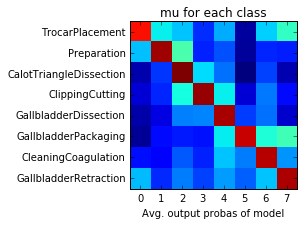

In [14]:
# Display mus

plt.figure(figsize=(3,3))
plt.imshow(mus, interpolation="nearest")
plt.title("mu for each class")
plt.yticks(range(p),ordered_unique_steps)
plt.xlabel("Avg. output probas of model")
plt.show()

## Applying the HMM

### Parameters

Set the models parameters with what we computed before

In [15]:
model = hmm.GaussianHMM(n_components=p, covariance_type="full")
model.startprob_ = pi
model.transmat_ = A
model.means_ = mus
model.covars_ = sigmas

### Sample

Generate a sample to check for weird behavior

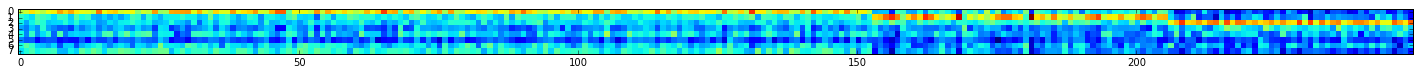

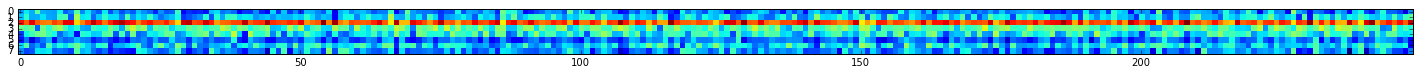

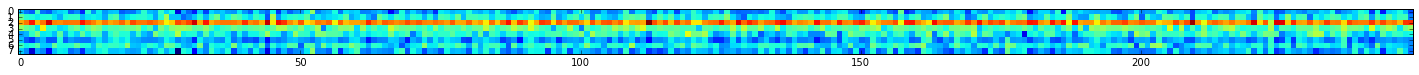

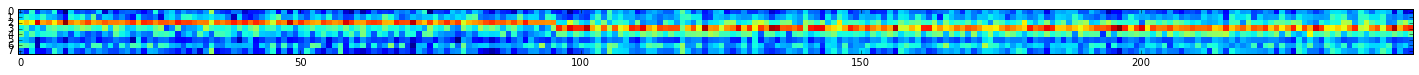

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [16]:
X, Z = model.sample(1000)
plt.figure(figsize=(25, 5))
plt.imshow(X[0:250, :].T, interpolation="nearest")
plt.show()
plt.figure(figsize=(25, 5))
plt.imshow(X[251:500, :].T, interpolation="nearest")
plt.show()
plt.figure(figsize=(25, 5))
plt.imshow(X[501:750, :].T, interpolation="nearest")
plt.show()
plt.figure(figsize=(25, 5))
plt.imshow(X[751:1000, :].T, interpolation="nearest")
plt.show()
print Z

### Decoding a sequence

In [40]:
test_pred_probas

[[[6.3713693618774,
   -4.4004583358765,
   -3.0545217990875,
   -3.2996451854706,
   -1.9027019739151,
   -7.282829284668,
   -2.5461518764496,
   -0.32938498258591],
  [4.5211143493652,
   -3.7382311820984,
   -2.8181946277618,
   -2.7585654258728,
   -0.77000617980957,
   -7.0827836990356,
   -1.7210820913315,
   0.74420166015625],
  [0.91373682022095,
   -0.81257843971252,
   -1.8526265621185,
   -2.7554306983948,
   -5.1314406394958,
   -4.5916948318481,
   -0.31444400548935,
   2.2834882736206],
  [0.99121904373169,
   -1.0240795612335,
   -1.2902661561966,
   -2.2138464450836,
   -1.0501402616501,
   -2.9545679092407,
   -0.24982316792011,
   1.0593543052673],
  [3.7776806354523,
   -2.1097776889801,
   -2.9760701656342,
   -3.9913454055786,
   -3.094936132431,
   -3.4308762550354,
   1.9033905267715,
   -0.011713973246515],
  [6.6653575897217,
   -3.3445844650269,
   -2.9961266517639,
   -5.48970079422,
   -3.1218287944794,
   -5.8701272010803,
   -0.52323198318481,
   -0.12016

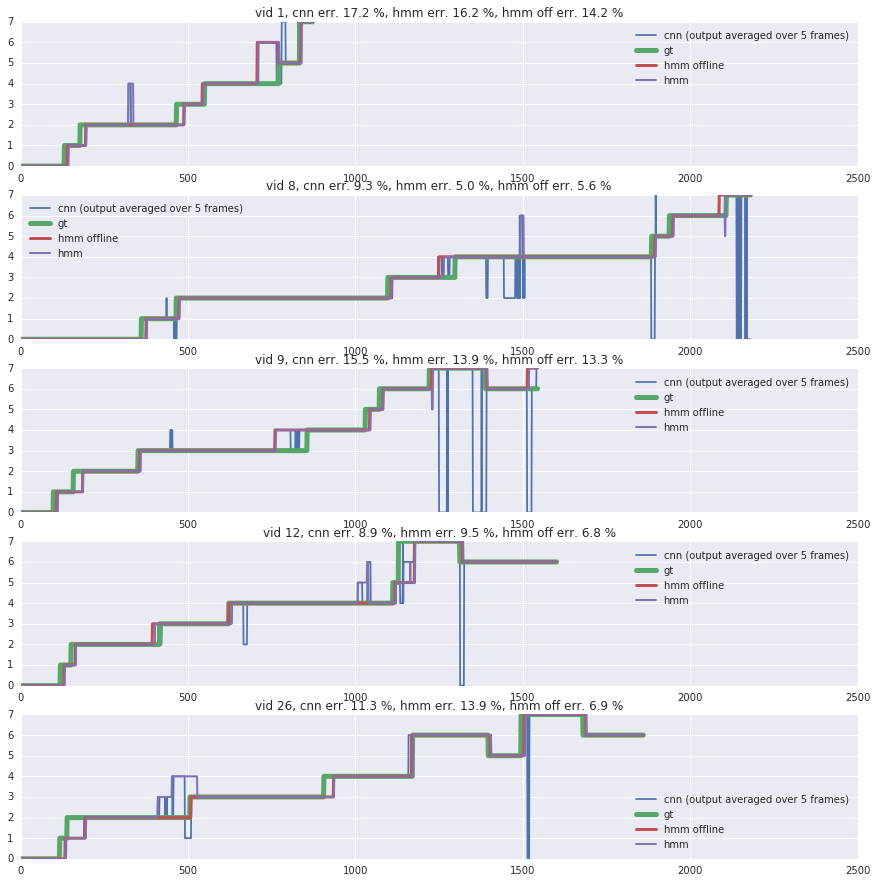

In [66]:
import seaborn

VAL = True
SAVE = True

plt.figure(figsize=(15,15))
for testInd in range(len(test_pred_probas_ids)):

    vidInd = test_pred_probas_ids[testInd]
    probas = np.array(test_pred_probas[testInd])
    
    if VAL:
        steps_gt = test_pred_probas_gt[testInd]
    
    # lissage
    #p = 5
    #ps2 = p/2 # auto floored
    #tmp = probas[ps2:-ps2] * 0
    #for i in range(p-1):
    #    tmp += probas[i:-p+i+1, :]
    #probas[ps2:-ps2] = (tmp + probas[p-1:, :]) / p
    #probas[2:-2] = (probas[0:-4, :] + probas[1:-3, :] + probas[2:-2, :] + probas[3:-1, :] + probas[4:, :]) / 5
    for i in range(1,12):
        probas[i:] = (i * probas[i:] + probas[:-i]) / (i + 1)
    
    # pred
    steps_hat_cnn = np.argmax(np.array(probas), axis=1)
    (_, steps_hat_hmm_off) = model.decode(probas)
    steps_hat_hmm = np.array(steps_hat_cnn) * 0
    for i in range(len(probas)):
        (_, steps_hat_hmm_tmp) = model.decode(probas[:i+1])
        steps_hat_hmm[i] = steps_hat_hmm_tmp[-1]

    # plot
    title = "vid %d, " % vidInd
    if VAL:
        title += "cnn err. %.1f %%, " % (np.sum(np.array(steps_gt) != np.array(steps_hat_cnn)) * 100.0 / len(steps_gt))
        title += "hmm err. %.1f %%, " % (np.sum(np.array(steps_gt) != np.array(steps_hat_hmm)) * 100.0 / len(steps_gt))
        title += "hmm off err. %.1f %%" % (np.sum(np.array(steps_gt) != np.array(steps_hat_hmm_off)) * 100.0 / len(steps_gt))
    plt.subplot(5,1,testInd+1)
    plt.title(title)
    plt.plot(range(len(steps_hat_cnn)), steps_hat_cnn, label="cnn (output averaged over 5 frames)")
    if VAL:
        plt.plot(range(len(steps_gt)), steps_gt, lw=5, label="gt")
    plt.plot(range(len(steps_hat_hmm_off)), steps_hat_hmm_off, lw=3, label="hmm offline")
    plt.plot(range(len(steps_hat_hmm)), steps_hat_hmm, lw=2, label="hmm")
    plt.xlim([0,2500])
    plt.legend(loc="best")
    
    
    # adjust length and save
    if VAL:
        targetLen = videos_true_length[vidInd]
    else:
        targetLen = videos_true_length[vidInd] # TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
    
    steps_hat_cnn = list(chain(*zip(*[steps_hat_cnn for _ in range(25)])))
    steps_hat_hmm = list(chain(*zip(*[steps_hat_hmm for _ in range(25)])))
    steps_hat_hmm_off = list(chain(*zip(*[steps_hat_hmm_off for _ in range(25)])))
    
    steps_hat_cnn = steps_hat_cnn[0:targetLen] # crop if too long
    steps_hat_cnn += [steps_hat_cnn[-1]] * (targetLen - len(steps_hat_cnn)) # pad if too short
    
    steps_hat_hmm = steps_hat_hmm[0:targetLen] # crop if too long
    steps_hat_hmm += [steps_hat_hmm[-1]] * (targetLen - len(steps_hat_hmm)) # pad if too short
    
    steps_hat_hmm_off = steps_hat_hmm_off[0:targetLen] # crop if too long
    steps_hat_hmm_off += [steps_hat_hmm_off[-1]] * (targetLen - len(steps_hat_hmm_off)) # pad if too short
    
    if SAVE:
        f = open("../predictions/val_cnn/workflow_video_%02d_pred.txt" % (vidInd+1), "w")
        f.write("Frame\tPhase\n")
        for i, step in enumerate(steps_hat_cnn):
            f.write("%d\t%s\n" % (i, ordered_unique_steps[step]))
        f.close()

        f = open("../predictions/val_hmm/workflow_video_%02d_pred.txt"% (vidInd+1), "w")
        f.write("Frame\tPhase\n")
        for i, step in enumerate(steps_hat_hmm):
            f.write("%d\t%s\n" % (i, ordered_unique_steps[step]))
        f.close()
        
        f = open("../predictions/val_hmm_off/workflow_video_%02d_pred.txt"% (vidInd+1), "w")
        f.write("Frame\tPhase\n")
        for i, step in enumerate(steps_hat_hmm_off):
            f.write("%d\t%s\n" % (i, ordered_unique_steps[step]))
        f.close()
    
plt.show()

## Export

```
Frame	Phase
0	TrocarPlacement
...
```

```python
for testInd in range(len(test_pred_probas_ids)):

    vidInd = test_pred_probas_ids[testInd]
    probas = np.array(test_pred_probas[testInd])
    
    # lissage
    p = 5
    ps2 = p/2 # auto floored
    tmp = probas[ps2:-ps2] * 0
    for i in range(p-1):
        tmp += probas[i:-p+i+1, :]
    probas[ps2:-ps2] = (tmp + probas[p-1:, :]) / p
    #probas[2:-2] = (probas[0:-4, :] + probas[1:-3, :] + probas[2:-2, :] + probas[3:-1, :] + probas[4:, :]) / 5
    
    # pred
    steps_hat_cnn = np.argmax(np.array(probas), axis=1)
    #(_, steps_hat_hmm) = model.decode(probas)
    steps_hat_hmm = np.array(steps_hat_cnn) * 0
    for i in range(len(probas)):
        (_, steps_hat_hmm_tmp) = model.decode(probas[:i+1])
        steps_hat_hmm[i] = steps_hat_hmm_tmp[-1]

    steps_hat_cnn = list(chain(*zip(*[steps_hat_cnn for _ in range(25)])))
    steps_hat_hmm = list(chain(*zip(*[steps_hat_hmm for _ in range(25)])))
    
    targetLen = videos_true_length[vidInd]
    steps_hat_cnn = steps_hat_cnn[0:targetLen] # crop if too long
    steps_hat_cnn += [steps_hat_cnn[-1]] * (targetLen - len(steps_hat_cnn)) # pad if too short
    
    steps_hat_hmm = steps_hat_hmm[0:targetLen] # crop if too long
    steps_hat_hmm += [steps_hat_hmm[-1]] * (targetLen - len(steps_hat_hmm)) # pad if too short
    
    f = open("../predictions/val_cnn/workflow_video_%02d_pred.txt" % (vidInd+1), "w")
    f.write("Frame\tPhase\n")
    for i, step in enumerate(steps_hat_cnn):
        f.write("%d\t%s\n" % (i, ordered_unique_steps[step]))
    f.close()
    
    f = open("../predictions/val_hmm/workflow_video_%02d_pred.txt"% (vidInd+1), "w")
    f.write("Frame\tPhase\n")
    for i, step in enumerate(steps_hat_hmm):
        f.write("%d\t%s\n" % (i, ordered_unique_steps[step]))
    f.close()
```